In [1]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

SET UP A BASIC LSTM MODEL 
'''

'\nDeep Learning Stock Price Predictor \nAuthor: Gil Akos\nObjective: Create Deep Learning Model with Keras LSTM\nReference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/\n\nSET UP A BASIC LSTM MODEL \n'

In [81]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [67]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

In [259]:
bitcoin_hist = pd.read_csv("data/Bitcoin Historical Data - Investing.com.csv")
sp500_hist = pd.read_csv("data/S&P 500 Historical Data.csv")
dax_hist = pd.read_csv("data/DAX Historical Data.csv")
googl_hist = pd.read_csv("data/GOOGL Historical Data.csv")

In [260]:
def convert_values(row, col):
    val = row[col].replace(",","")
    return float(val)

def convert_vol(row, col):
    letter = row[col][-1]
    val = row[col].rstrip(letter)
    val = float(val)
    if letter=="M":
        val = val*1000000
    if letter=="K":
        val = val*1000
    
    return val
    

In [261]:
def prep_charts(df):
    df["Price"] = df.apply(convert_values, args=("Price",), axis=1)
    df["Open"] = df.apply(convert_values, args=("Open",), axis=1)
    df["High"] = df.apply(convert_values, args=("High",), axis=1)
    df["Low"] = df.apply(convert_values, args=("Low",), axis=1)

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by="Date").reset_index()
    del df["index"]

    df["price_norm"] = df["Price"] / df["Price"].max()
    
    return df

In [262]:
bitcoin_hist = prep_charts(bitcoin_hist)
sp500_hist = prep_charts(sp500_hist)
dax_hist = prep_charts(dax_hist)
googl_hist = prep_charts(googl_hist)

In [263]:
bitcoin_hist["Vol."] = bitcoin_hist.apply(convert_vol, args=("Vol.",), axis=1)
bitcoin_hist["30_day_ma"] = bitcoin_hist["Price"].rolling(window=30, min_periods=1).mean()
bitcoin_hist["30_day_std"] = bitcoin_hist["Price"].rolling(window=30, min_periods=1).std()
bitcoin_hist["boll_upp"] = bitcoin_hist['30_day_ma'] + (bitcoin_hist['30_day_std'] * 2)
bitcoin_hist["boll_low"] = bitcoin_hist['30_day_ma'] - (bitcoin_hist['30_day_std'] * 2)

In [264]:
bitcoin_hist.head()

,Date,Price,Open,High,Low,Vol.,Change %,price_norm,30_day_ma,30_day_std,boll_upp,boll_low
0,2015-01-01,314.9,318.2,321.4,313.5,12820.0,-1.05%,0.016278,314.900000,NaN,NaN,NaN
1,2015-01-02,315.2,314.9,316.4,313.1,14730.0,0.10%,0.016293,315.050000,0.212132,315.474264,314.625736
2,2015-01-03,287.1,315.2,315.8,284.9,47370.0,-8.91%,0.014841,305.733333,16.137637,338.008608,273.458059
3,2015-01-04,264.7,287.1,289.9,255.9,88770.0,-7.80%,0.013683,295.475000,24.383379,344.241758,246.708242
4,2015-01-05,274.8,264.7,278.3,262.9,54990.0,3.82%,0.014205,291.340000,23.052180,337.444360,245.235640


In [231]:
bitcoin_hist.shape

(1903, 12)

In [304]:
sp500_hist.tail()

,Date,Price,Open,High,Low,Vol.,Change %,price_norm
1305,2020-03-11,2741.38,2825.60,2825.60,2707.22,-,-4.89%,0.809586
1306,2020-03-12,2480.64,2630.86,2660.95,2478.86,-,-9.51%,0.732584
1307,2020-03-13,2711.02,2569.99,2711.33,2492.37,-,9.29%,0.800620
1308,2020-03-16,2386.13,2508.59,2562.98,2380.94,-,-11.98%,0.704673
1309,2020-03-17,2506.91,2446.80,2556.28,2367.78,-,5.06%,0.740342


In [233]:
dax_hist.tail()

,Date,Price,Open,High,Low,Vol.,Change %,price_norm
1312,2020-03-11,10438.68,10601.85,10761.43,10390.51,216.71M,-0.35%,0.757030
1313,2020-03-12,9161.13,9863.99,9932.56,9139.12,390.48M,-12.24%,0.664380
1314,2020-03-13,9232.08,9480.78,9985.74,9064.68,325.90M,0.77%,0.669525
1315,2020-03-16,8742.25,8728.48,8967.11,8255.65,302.20M,-5.31%,0.634002
1316,2020-03-17,8939.10,9141.17,9145.93,8423.56,-,2.25%,0.648278


In [234]:
trend_df = pd.read_csv("data/trends_bitcoin_cc_eth_trading_etf.csv")

In [235]:
trend_df.head()

,date,bitcoin,cryptocurrency,ethereum,trading,etf,isPartial
0,2015-01-08 00:00:00,29,1,0,79,10,False
1,2015-01-08 01:00:00,22,0,0,93,10,False
2,2015-01-08 02:00:00,26,0,0,87,9,False
3,2015-01-08 03:00:00,21,0,0,80,11,False
4,2015-01-08 04:00:00,20,0,0,87,11,False


In [236]:
trend_df['date'] = pd.to_datetime(trend_df['date'])

In [237]:
trend_df.head()

,date,bitcoin,cryptocurrency,ethereum,trading,etf,isPartial
0,2015-01-08 00:00:00,29,1,0,79,10,False
1,2015-01-08 01:00:00,22,0,0,93,10,False
2,2015-01-08 02:00:00,26,0,0,87,9,False
3,2015-01-08 03:00:00,21,0,0,80,11,False
4,2015-01-08 04:00:00,20,0,0,87,11,False


In [238]:
trend_df = trend_df.set_index("date")

In [239]:
trend_df = trend_df.resample("D").sum()

In [273]:
trend_df.reset_index(inplace=True)

In [243]:
sent_df = pd.read_csv("data/bitcoin_sentiments.csv")

In [248]:
sent_df["date"] = pd.to_datetime(sent_df["date"])

In [246]:
sent_df["quot"] = sent_df["pos"] / sent_df["neg"]

In [250]:
sent_df.head()

,date,length,pos,neg,quot
0,2015-01-01,1716,0.153879,0.043424,3.543662
1,2015-01-02,1699,0.134617,0.035322,3.811138
2,2015-01-03,1719,0.141888,0.061588,2.303847
3,2015-01-04,1320,0.131757,0.060844,2.165488
4,2015-01-05,1228,0.107428,0.072953,1.472563


In [318]:
corr_df = bitcoin_hist[["Date","Price", "High", "Low", "30_day_ma", "30_day_std", "boll_upp", "boll_low"]]
corr_df.columns = ["bitcoin_{}".format(x) for x in corr_df.columns]
corr_df.merge(sp500_hist[["Date","Price"]], left_on="bitcoin_Date", right_on="Date", how="right").drop(columns=["Date"])

,bitcoin_Date,bitcoin_Price,bitcoin_High,bitcoin_Low,bitcoin_30_day_ma,bitcoin_30_day_std,bitcoin_boll_upp,bitcoin_boll_low,Price
0,2015-01-02,315.2,316.4,313.1,315.050000,0.212132,315.474264,314.625736,2058.20
1,2015-01-05,274.8,278.3,262.9,291.340000,23.052180,337.444360,245.235640,2020.58
2,2015-01-06,282.3,285.1,271.5,289.833333,20.946185,331.725703,247.940963,2002.61
3,2015-01-07,291.3,296.1,280.7,290.042857,19.129197,328.301252,251.784462,2025.90
4,2015-01-08,282.7,292.7,279.0,289.125000,17.899461,324.923923,253.326077,2062.14
...,...,...,...,...,...,...,...,...,...
1305,2020-03-11,7935.1,7976.5,7606.0,9233.006667,758.577806,10750.162279,7715.851054,2741.38
1306,2020-03-12,4826.0,7963.1,4546.6,9052.890000,1085.058663,11223.007326,6882.772674,2480.64
1307,2020-03-13,5584.3,5934.3,3869.5,8895.110000,1229.350167,11353.810334,6436.409666,2711.02
1308,2020-03-16,5030.0,5369.3,4477.7,8398.550000,1583.489404,11565.528809,5231.571191,2386.13


In [310]:
corr_df.tail()

,bitcoin_Date,bitcoin_Price,bitcoin_High,bitcoin_Low,bitcoin_30_day_ma,bitcoin_30_day_std,bitcoin_boll_upp,bitcoin_boll_low,sp500_Price
1898,2020-03-13,5584.3,5934.3,3869.5,8895.110000,1229.350167,11353.810334,6436.409666,NaN
1899,2020-03-14,5182.7,5634.9,5072.2,8726.696667,1376.693646,11480.083958,5973.309375,NaN
1900,2020-03-15,5366.3,5863.3,5120.6,8561.140000,1472.191206,11505.522413,5616.757587,NaN
1901,2020-03-16,5030.0,5369.3,4477.7,8398.550000,1583.489404,11565.528809,5231.571191,NaN
1902,2020-03-17,5271.3,5405.7,4946.5,8243.183333,1654.865987,11552.915307,4933.451360,NaN


In [290]:
corr_df = bitcoin_hist[["Date","Price", "High", "Low", "30_day_ma", "30_day_std", "boll_upp", "boll_low"]]
corr_df.columns = ["bitcoin_{}".format(x) for x in corr_df.columns]
corr_df.loc[:,"sp500_Price"] = sp500_hist["Price"]
corr_df.loc[:,"dax500_Price"] = dax_hist["Price"]
corr_df.loc[:,"google_Price"] = googl_hist["Price"]


In [291]:
corr_df = corr_df.merge(trend_df, left_on="bitcoin_Date", right_on="date").drop(columns=["date", "etf", "ethereum", "isPartial"])

In [292]:
corr_df = corr_df.rename(columns={"bitcoin":"bitcoin_Google_Trends", 
                        "cryptocurrency":"cryptocurrency_Google_Trends",
                        "trading":"trading_Google_Trends"})

In [293]:
corr_df = corr_df.merge(sent_df, left_on="bitcoin_Date", right_on="date").drop(columns=["date", "length"])

In [294]:
corr_df = corr_df.rename(columns={"pos": "bitcoin_pos_sents",
                                  "neg": "bitcoin_neg_sents",
                                  "quot": "bitcoin_quot_sents"})

In [303]:
corr_df.tail()

,bitcoin_Date,bitcoin_Price,bitcoin_High,bitcoin_Low,bitcoin_30_day_ma,bitcoin_30_day_std,bitcoin_boll_upp,bitcoin_boll_low,sp500_Price,dax500_Price,google_Price,bitcoin_Google_Trends,cryptocurrency_Google_Trends,trading_Google_Trends,bitcoin_pos_sents,bitcoin_neg_sents,bitcoin_quot_sents
1883,2020-03-06,9134.8,9165.2,9004.9,9526.690000,577.462345,10681.614691,8371.765309,NaN,NaN,NaN,826,163,659,0.143554,0.057431,2.499613
1884,2020-03-07,8887.8,9180.8,8848.7,9497.216667,586.995951,10671.208569,8323.224764,NaN,NaN,NaN,665,51,681,0.149116,0.080266,1.857773
1885,2020-03-08,8034.1,8888.0,8015.3,9437.733333,641.217546,10720.168425,8155.298242,NaN,NaN,NaN,730,50,665,0.135045,0.076425,1.767035
1886,2020-03-09,7933.0,8158.8,7648.7,9372.316667,691.074380,10754.465427,7990.167907,NaN,NaN,NaN,1237,61,1056,0.175497,0.136439,1.286267
1887,2020-03-10,7891.2,8145.5,7740.2,9296.973333,725.548818,10748.070970,7845.875697,NaN,NaN,NaN,47,3,44,0.167861,0.086850,1.932779


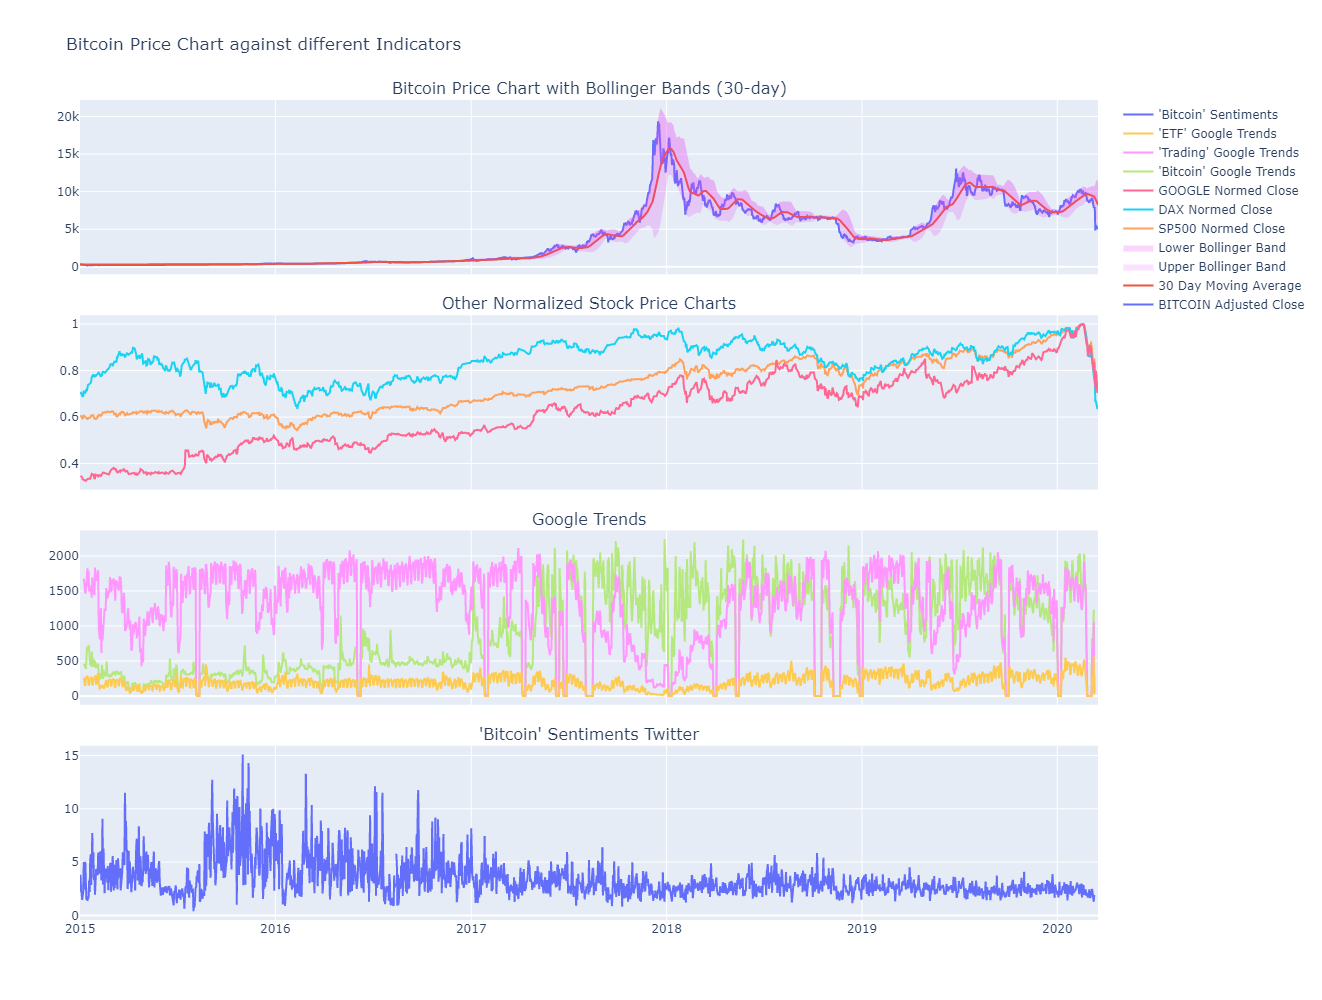

In [255]:
fig = make_subplots(
    rows=4, 
    cols=1, 
    shared_xaxes=True, 
    vertical_spacing=0.05,
    subplot_titles=("Bitcoin Price Chart with Bollinger Bands (30-day)", 
                    "Other Normalized Stock Price Charts", 
                    "Google Trends", 
                    "'Bitcoin' Sentiments Twitter")
)

#fig = go.Figure()

fig.add_trace(go.Scatter(x=bitcoin_hist['Date'], 
                         y=bitcoin_hist['Price'],
                         name="BITCOIN Adjusted Close"), row=1, col=1)

fig.add_trace(go.Scatter(x=bitcoin_hist['Date'], 
                         y=bitcoin_hist['30_day_ma'],
                         name="30 Day Moving Average"), row=1, col=1)

fig.add_trace(go.Scatter(x=bitcoin_hist['Date'], 
                         y=bitcoin_hist['boll_upp'],
                         fill='tonexty',
                         fillcolor='rgba(231,107,243,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         name="Upper Bollinger Band"), row=1, col=1)

fig.add_trace(go.Scatter(x=bitcoin_hist['Date'], 
                         y=bitcoin_hist['boll_low'],
                         fill='tonexty',
                         fillcolor='rgba(231,50,243,0.2)',
                         line=dict(color='rgba(255,255,255,0)'),
                         name="Lower Bollinger Band"), row=1, col=1)


fig.add_trace(go.Scatter(x=sp500_hist['Date'], 
                         y=sp500_hist['price_norm'],
                         name="SP500 Normed Close"), row=2, col=1)

fig.add_trace(go.Scatter(x=dax_hist['Date'], 
                         y=dax_hist['price_norm'],
                         name="DAX Normed Close"), row=2, col=1)


fig.add_trace(go.Scatter(x=googl_hist['Date'], 
                         y=googl_hist['price_norm'],
                         name="GOOGLE Normed Close"), row=2, col=1)


fig.add_trace(go.Scatter(x=trend_df.index,
                         y=trend_df["bitcoin"],
                         name="'Bitcoin' Google Trends"), row=3, col=1)

fig.add_trace(go.Scatter(x=trend_df.index,
                         y=trend_df["trading"],
                         name="'Trading' Google Trends"), row=3, col=1)

fig.add_trace(go.Scatter(x=trend_df.index,
                         y=trend_df["etf"],
                         name="'ETF' Google Trends"), row=3, col=1)

fig.add_trace(go.Scatter(x=sent_df["date"],
                         y=sent_df["quot"],
                         name="'Bitcoin' Sentiments"), row=4, col=1)


fig.update_layout(height=1000, width=1500, title_text="Bitcoin Price Chart against different Indicators")

fig.show()

In [216]:


#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

stock_temp = []
#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for index, row in bitcoin_hist.iterrows():
    temp_d = {}
    temp_d['index'] = index
    temp_d['date'] = row["Date"]
    temp_d['price'] = float(row["Price"])
    temp_d['volume'] = float(row['Vol.'])
    stock_temp.append(temp_d)

#Create a dataframe for stock data
stock_df = pd.DataFrame(stock_temp)
stock_df.set_index("index", inplace=True)


#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

            date  price   volume
index                           
0     2015-01-01  314.9  12820.0
1     2015-01-02  315.2  14730.0
2     2015-01-03  287.1  47370.0
3     2015-01-04  264.7  88770.0
4     2015-01-05  274.8  54990.0
---
            date   price     volume
index                              
1898  2020-03-13  5584.3  4170000.0
1899  2020-03-14  5182.7  1690000.0
1900  2020-03-15  5366.3  1610000.0
1901  2020-03-16  5030.0  2550000.0
1902  2020-03-17  5271.3  2020000.0


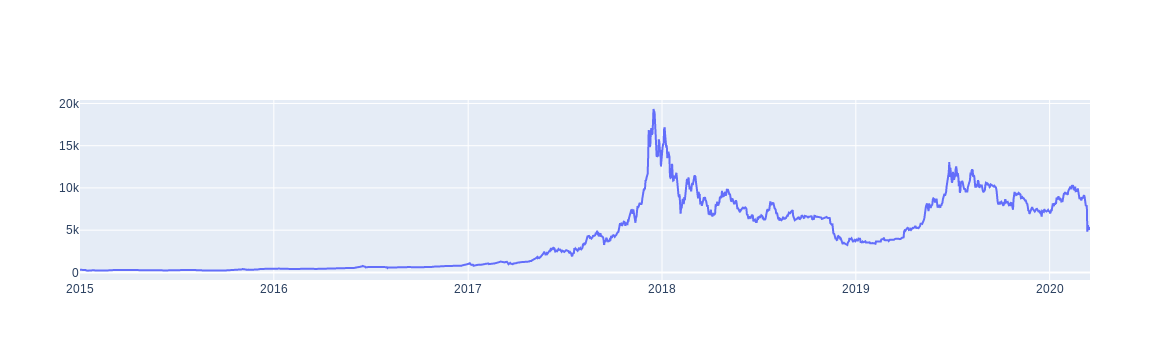

In [217]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_df['date'], y=stock_df['price']))
fig.show()


In [33]:
#Create numpy arrays for features and targets
X_day_all = []
close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_day_all.append([(row['date'])])
    close_all.append([(row['price'])])


In [88]:
# Reshape into t and t+1
look_back = 100 #50
tt_split = (1.0-.315)
#X_day_train_t, X_day_train_t1, X_day_test_t, X_day_test_t1 = create_dataset(X_day_all, look_back, tt_split, True)
#X_vol_train_t, X_vol_train_t1 = create_dataset(X_vol_train, look_back, True)
X_price_train, y_price_train, X_price_test, y_price_test, close_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)


In [35]:
np.shape(close_all)

(1903, 1)

In [36]:
np.shape(X_price_train)

(1234, 100, 1)

In [37]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Set up hyperparameters
batch_size = 1
epochs = 1 # 200
n_nodes = [128]

# Create the LSTM model
model = Sequential()
model.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back, 1)))
model.add(Dense(1))
model.add(Activation('linear'))

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.011012077331542969


In [38]:
# Train the model
model.fit(X_price_train, 
          y_price_train, 
          nb_epoch=epochs, 
          batch_size=batch_size, 
          verbose=2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 1/1
 - 23s - loss: 0.0018


In [39]:
# Generate predictions for training
testPredict = model.predict(X_price_test, batch_size=batch_size)
#testPredict = util.predict_sequences(model, X_close_test)


In [40]:
np.shape(X_price_test)

(568, 100, 1)

In [89]:
#probPredict = model.predict_proba(X_price_test)

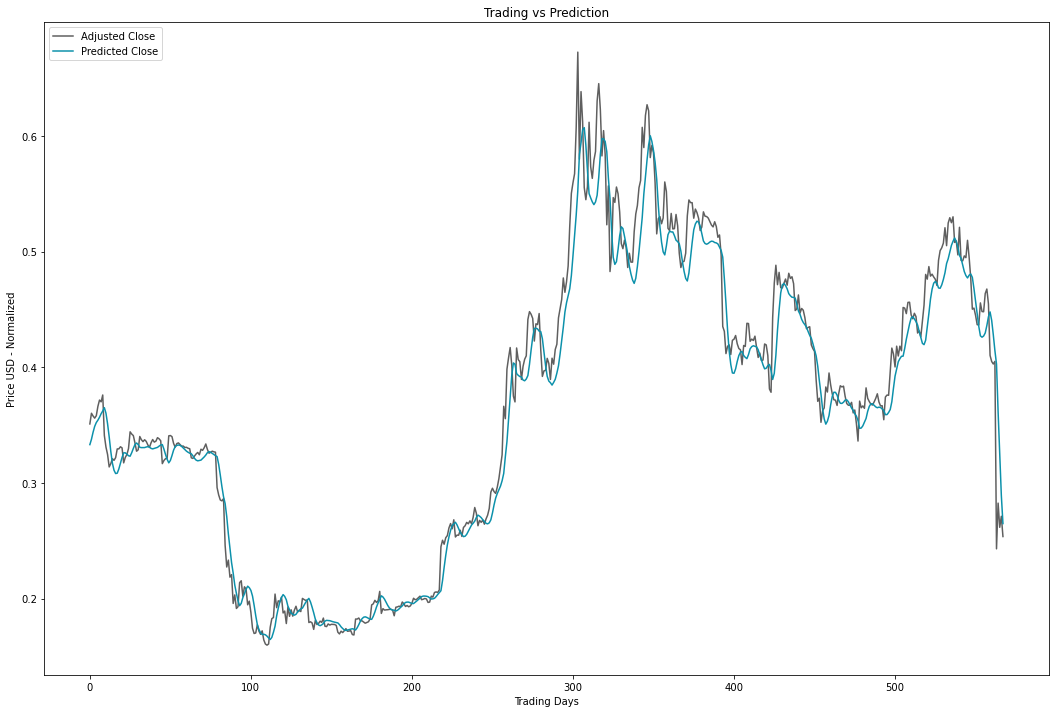

In [90]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(y_price_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()



In [42]:
len(y_price_test)

568

In [43]:
len(testPredict)

568

In [44]:
len(y_price_test)

568

In [45]:
test_df = pd.DataFrame()

In [46]:
test_df["date"] = [x[0] for x in X_day_all[-(len(y_price_test)):] ]

In [47]:
test_df["price"] = y_price_test

In [48]:
test_df["predict"] = testPredict

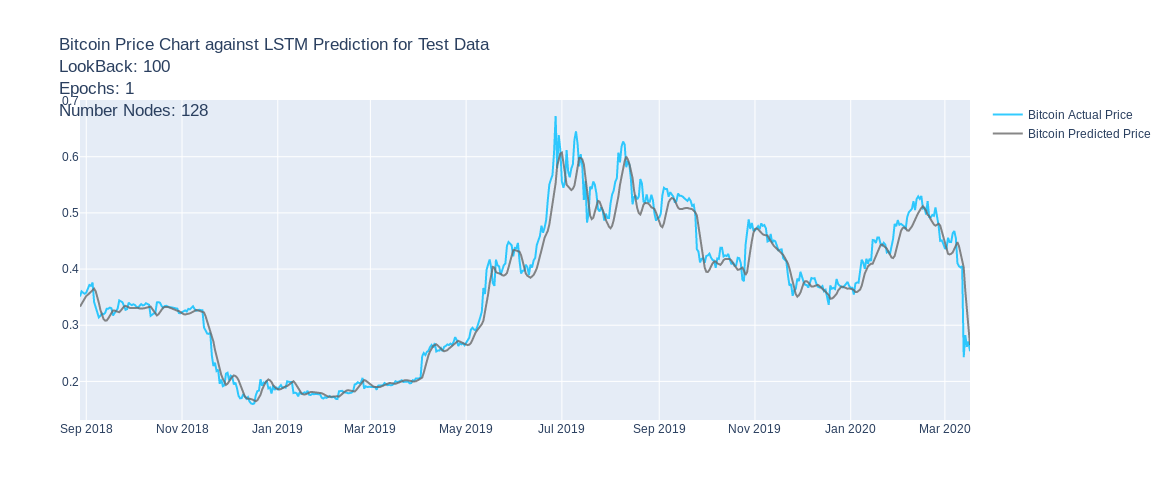

In [299]:
# Plot the predictions

fig = go.Figure()

fig.add_trace(go.Scatter(
                x=test_df["date"],
                y=test_df["price"],
                name="Bitcoin Actual Price",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=test_df["date"],
                y=test_df["predict"],
                name="Bitcoin Predicted Price",
                line_color='dimgray',
                opacity=0.8))

#fig.update_layout(xaxis_range=['2015-01-01','2020-03-10'],
#                  title_text="Manually Set Date Range")

fig.update_layout(height=500, width=1000, title_text="Bitcoin Price Chart against LSTM Prediction for Test Data<br>LookBack: 100<br>Epochs: 1<br>Number Nodes: 128")
fig.show()

In [300]:
# The mean squared error
testScore = model.evaluate(X_price_test, y_price_test, batch_size=batch_size, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.000573 MSE (0.023932 RMSE)


In [ ]:
# Plot the predictions
close_plot = close_all[-y_close_test.shape[0]:]

pred_seq = np.array(testPredict)
#pprint(pred_seq)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)
#pprint(preds_seq_plot)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')


# Log of Results:


### SPY
Epochs: 1 NumNodes: 8 Test Score: 0.000669 MSE (0.025867 RMSE)

Epochs: 1 NumNodes: 16 Test Score: 0.000121 MSE (0.010997 RMSE)

Epochs: 1 NumNodes: 32 Test Score: 0.000160 MSE (0.012635 RMSE)

Epochs: 1 NumNodes: 64 Test Score: 0.000236 MSE (0.015360 RMSE)

Epochs: 1 NumNodes: 128 Test Score: 0.000074 MSE (0.008631 RMSE)

### GE
Epochs: 1 NumNodes: 128 Test Score: 0.000075 MSE (0.008657 RMSE)

### MSFT
Epochs: 1 NumNodes: 128 Test Score: 0.000163 MSE (0.012776 RMSE)

### AAPL
Epochs: 1 NumNodes: 128 Test Score: 0.000100 MSE (0.009992 RMSE)